In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
from luxtools.scientific import NumericResult
from matplotlib.cm import ScalarMappable, get_cmap
from matplotlib.colors import Normalize
from numpy import array
from common import NodeType

In [2]:
data_dir = "data"

base_names = {
    "0": "rollout_sphere_base.pkl",
    "45": "rollout_sphere_base_45.pkl",
}


model_names = {
    "0": "rollout_sphere_model.pkl",
    "45": "rollout_sphere_model_45_fixed.pkl",
}

layer_names: dict = {
    "0": "rollout_sphere_layers.pkl",
    "45": "rollout_sphere_layers_45_fixed.pkl",
}

In [3]:
def load_data(names: dict):
    res = {}
    for keys, paths in names.items():
        with open(f"{data_dir}/{paths}", "rb") as f:
            res[keys] = pickle.load(f)
    return res

In [4]:
base = load_data(base_names)
model = load_data(model_names)
layer = load_data(layer_names)

In [5]:
def rotation_matrix_z(angle: float):
    """Generates appropriate rotation matrix for z-axis given a rotation angle in degrees.

    Args:
        angle (float): rotation angle [degrees]

    Returns:
        tf.Tensor: Rotation matrix
    """
    angle = angle * np.pi / 180
    return np.array(
            [
                [np.cos(angle), -np.sin(angle), 0],
                [np.sin(angle), np.cos(angle), 0],
                [0, 0, 1],
            ],
            dtype=np.float32,
        )

In [6]:
def test_equivariance(data, angle=45, step=-1, use_gt=False):
    mses = []

    rotate_back_matrix = rotation_matrix_z(-angle)

    pos_key = "gt_pos" if use_gt else "pred_pos"

    for i in range(len(data['0'])):
        not_rotated = data["0"][i][pos_key]
        rotated = data[str(angle)][i][pos_key]

        rotated_back = np.einsum("sni,ij->snj", rotated, rotate_back_matrix)

        # print(not_rotated.shape)
        # print((not_rotated - rotated_back) ** 2)
        mse = np.mean((not_rotated - rotated_back) ** 2, axis=(1,2))[step]
        # print(mse)
        # print(mse)
        mses.append(mse)

    mses = np.array(mses)
    return np.mean(mses), np.std(mses)

In [7]:
step = 5
gt_mean, gt_std = test_equivariance(base, use_gt=True, step=step) # data doesn't matter
base_mean, base_std = test_equivariance(base, step=step)
model_mean, model_std = test_equivariance(model, step=step)
layer_mean, layer_std = test_equivariance(layer, step=step)

print("(model(x)-model(Rx))R^(-1))^2")

print("step", step)
print(f'GT: {gt_mean} +- {gt_std}')
print(f"Base: {base_mean} +- {base_std}")
print(f"Model subeqv: {model_mean} +- {model_std}")
print(f"Layer subeqv: {layer_mean} +- {layer_std}")


step = -1
gt_mean, gt_std = test_equivariance(base, use_gt=True, step=step)  # data doesn't matter
base_mean, base_std = test_equivariance(base, step=step)
model_mean, model_std = test_equivariance(model, step=step)
layer_mean, layer_std = test_equivariance(layer, step=step)

print("step", base["0"][0]["pred_pos"].shape[0]+1)
print(f"GT: {gt_mean} +- {gt_std}")
print(f"Base: {base_mean} +- {base_std}")
print(f"Model subeqv: {model_mean} +- {model_std}")
print(f"Layer subeqv: {layer_mean} +- {layer_std}")


(model(x)-model(Rx))R^(-1))^2
step 5
GT: 2.5908789680730362e-16 +- 7.129608665937454e-17
Base: 0.8431860208511353 +- 0.24216929078102112
Model subeqv: 7.718368350321473e-15 +- 1.9433940659394034e-15
Layer subeqv: 2.3174936814029934e-06 +- 9.241851444130589e-07
step 500
GT: 2.185158656667699e-16 +- 1.47601195296566e-16
Base: 126.8746566772461 +- 26.791259765625
Model subeqv: 2.7643147404887713e-05 +- 6.433101953007281e-05
Layer subeqv: 0.0009753450867719948 +- 0.0003106330696027726


In [8]:
def compute_mse(data, angle, step=-1):
    mses = []

    for i in range(len(data['0'])):
        gt_pos = data[str(angle)][i]["gt_pos"]
        pred_pos = data[str(angle)][i]["pred_pos"]

        mse = np.mean((gt_pos - pred_pos) ** 2, axis=(1,2))[step]
        # print(mse)
        mses.append(mse)

    mses = np.array(mses)
    return np.mean(mses), np.std(mses)

In [9]:
traj = 5
step = 50
rot_angle = 45

def compute_mse_traj(data, angle, traj, step=-1):
    mses = []


    gt_pos = data[str(angle)][traj]["gt_pos"]
    pred_pos = data[str(angle)][traj]["pred_pos"]

    mse = np.mean((gt_pos - pred_pos) ** 2, axis=(2))[step]
    mses.append(mse)

    mses = np.array(mses)
    return np.mean(mses), np.std(mses)

ds = model
(
    compute_mse_traj(ds, 0, traj, step=step),
    compute_mse_traj(ds, rot_angle, traj, step=step),
)

((0.036577813, 0.044681102), (0.036578268, 0.044681396))

In [10]:
from ast import Num


step = 5
base_mean0, base_std0 = compute_mse(base, 0, step=step)
base_mean45, base_std45 = compute_mse(base, 45, step=step)
model_mean0, model_std0 = compute_mse(model, 0, step=step)
model_mean45, model_std45 = compute_mse(model, 45, step=step)
layer_mean0, layer_std0 = compute_mse(layer, 0, step=step)
layer_mean45, layer_std45 = compute_mse(layer, 45, step=step)

print("MSE")
print("step", step)
print(f"Base 0: {NumericResult(float(base_mean0), float(base_std0)).latex()}")
print(f"Base 45: {NumericResult(float(base_mean45), float(base_std45)).latex()}")
print(f"Model 0: {NumericResult(float(model_mean0), float(model_std0)).latex()}")
print(f"Model 45: {NumericResult(float(model_mean45), float(model_std45)).latex()}")
print(f"Layer 0: {NumericResult(float(layer_mean0), float(layer_std0)).latex()}")
print(f"Layer 45: {NumericResult(float(layer_mean45), float(layer_std45)).latex()}")

step = -1
base_mean0, base_std0 = compute_mse(base, 0, step=step)
base_mean45, base_std45 = compute_mse(base, 45, step=step)
model_mean0, model_std0 = compute_mse(model, 0, step=step)
model_mean45, model_std45 = compute_mse(model, 45, step=step)
layer_mean0, layer_std0 = compute_mse(layer, 0, step=step)
layer_mean45, layer_std45 = compute_mse(layer, 45, step=step)

print("step", 500)
print(f"Base 0: {NumericResult(float(base_mean0), float(base_std0)).latex()}")
print(f"Base 45: {NumericResult(float(base_mean45), float(base_std45)).latex()}")
print(f"Model 0: {NumericResult(float(model_mean0), float(model_std0)).latex()}")
print(f"Model 45: {NumericResult(float(model_mean45), float(model_std45)).latex()}")
print(f"Layer 0: {NumericResult(float(layer_mean0), float(layer_std0)).latex()}")
print(f"Layer 45: {NumericResult(float(layer_mean45), float(layer_std45)).latex()}")


MSE
step 5
Base 0: (4 \pm 2)\cdot 10^{-6}
Base 45: (8 \pm 2)\cdot 10^{-1}
Model 0: (1 \pm 1)\cdot 10^{-5}
Model 45: (1 \pm 1)\cdot 10^{-5}
Layer 0: (2 \pm 3)\cdot 10^{-6}
Layer 45: (4 \pm 6)\cdot 10^{-6}
step 500
Base 0: (6 \pm 4)\cdot 10^{-2}
Base 45: (1.3 \pm 0.3)\cdot 10^{2}
Model 0: (10 \pm 4)\cdot 10^{-2}
Model 45: (10 \pm 4)\cdot 10^{-2}
Layer 0: (4 \pm 4)\cdot 10^{-2}
Layer 45: (4 \pm 4)\cdot 10^{-2}


## Figures

In [11]:
def plot_data(ax, data, angle, traj, step=-1, use_gt=False, alpha=1):
    data = data[str(angle)]
    pos_key = "gt_pos" if use_gt else "pred_pos"
    pos = data[traj][pos_key][step]
    faces = data[traj]["faces"][step]

    ax.plot_trisurf(
        pos[:, 0],
        pos[:, 1],
        faces,
        pos[:, 2],
        cmap=get_cmap("viridis"),
        norm=Normalize(vmin=pos[:, 2].min(), vmax=pos[:, 2].max()),
    )

def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i : i + n]

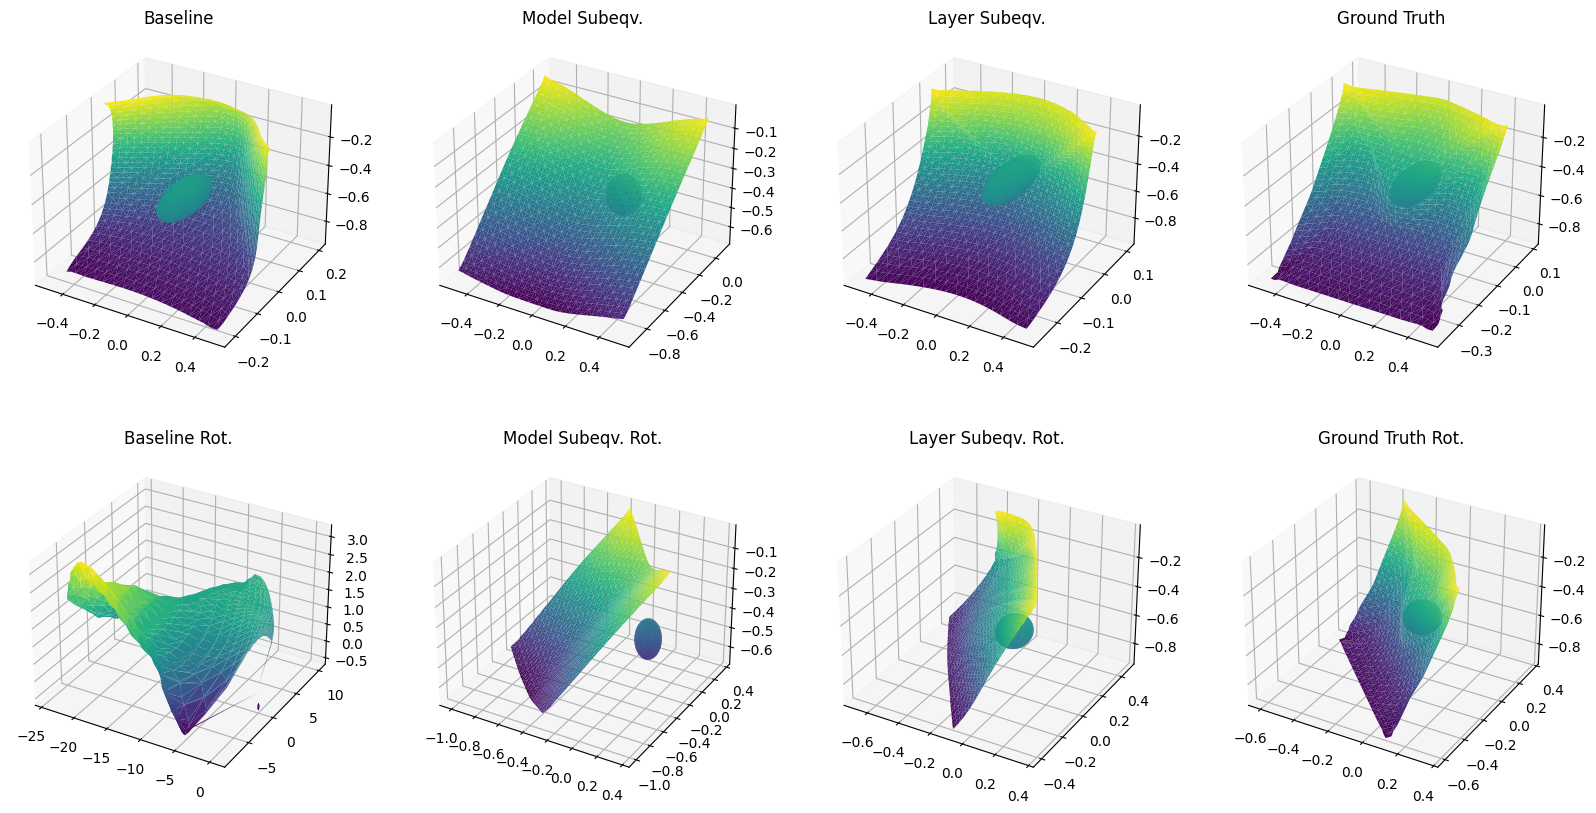

In [12]:
n_variants = 4
n_subvariant = 2
size = 5
fig = plt.figure(figsize=(size*n_variants, size*n_subvariant))


axes = [
    fig.add_subplot(n_subvariant, n_variants, i + 1, projection="3d")
    for i in range(n_subvariant * n_variants)
]

axes = np.array(axes).reshape(n_subvariant, n_variants).T

datasets = [base, model, layer]
dataset_names = ["Baseline", "Model Subeqv.", "Layer Subeqv."]

traj = 5
step = 50

for i in range(axes.shape[0]):
    axs = axes[i, :]
    if i == 3: break
    plot_data(axs[0], datasets[i], 0, traj, step=step, use_gt=False)
    plot_data(axs[1], datasets[i], 45, traj, step=step, use_gt=False)

    # plot gt
    # plot_data(axs[0], datasets[i], 0, traj, step=step, use_gt=True, alpha=0.5)
    # plot_data(axs[1], datasets[i], 45, traj, step=step, use_gt=True, alpha=0.5)

    axs[0].set_title(f"{dataset_names[i]}")
    axs[1].set_title(f"{dataset_names[i]} Rot.")

# set bounds
for ax in axes:
    bound = [[-0.5, -0.5, -0.5], [1, 1, 0.5]]
    # ax.set_xlim([bound[0][0], bound[1][0]])
    # ax.set_ylim([bound[0][1], bound[1][1]])
    # ax.set_zlim([bound[0][2], bound[1][2]])

# plot ground truth
# specific dataset doesn't matter
plot_data(axes[-1][0], datasets[0], 0,traj, step=step, use_gt=True)
plot_data(axes[-1][1], datasets[0], 45, traj, step=step, use_gt=True)

axes[-1][0].set_title("Ground Truth")
axes[-1][1].set_title("Ground Truth Rot.")

# fig.suptitle(f"Rollout Sphere Trajectory {traj} at step {step}")

plt.show()